# Jina Embeddings v3

Extra datacleaning

### Imports

In [1]:
# # Install necessary libraries if not already installed
# !pip install --upgrade torch torchvision
# !pip install flash-attn --no-build-isolation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from pathlib import Path
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from bs4 import BeautifulSoup
import random
import umap


## Step 2: Data cleaning 



#### Load data

In [2]:
df_csv = pd.read_csv(r"E:\Nieuw dataset\Dutch news articles 2015-2025 NOS.nl\articles_cleaned.csv")
df_csv.head()

,published_time,title,description,content,url,channel
0,2015/01/01,Euro nu ook in Litouwen,Vanaf vandaag betalen ze in Litouwen met de eu...,Euro nu ook in Litouwen In Litouwen wordt vana...,https://nos.nl/artikel/2011341-euro-nu-ook-in-...,nos
1,2015/01/01,Start 2015 vol vreugde maar ook met gewonden e...,Nederland is met oliebollen en vuurwerk het ni...,Start 2015 vol vreugde maar ook met gewonden e...,https://nos.nl/artikel/2011343-start-2015-vol-...,nos
2,2015/01/01,Letland nieuwe voorzitter van de Europese Unie,Vanaf vandaag neemt Letland het stokje over va...,Letland nieuwe voorzitter van de Europese Unie...,https://nos.nl/artikel/2011346-letland-nieuwe-...,nos
3,2015/01/01,Noord-Korea wil praten met Zuid-Korea,De Noord-Koreaanse leider Kim Jong-un zei in z...,Noord-Korea wil praten met Zuid-Korea De Noord...,https://nos.nl/artikel/2011348-noord-korea-wil...,nos
4,2015/01/01,"Feest in Londen, Parijs en Berlijn",In Londen en Berlijn waren muziekfestivals. Pa...,"Feest in Londen, Parijs en Berlijn In Europa i...",https://nos.nl/artikel/2011351-feest-in-londen...,nos


Woorden en carracters tellen voor en na de cleaning

voor embedding cleaning 

In [5]:
# Combine 'title', 'description', and 'content' into 'combined_text'
df_csv['combined_text'] = df_csv['title'].fillna('') + ". " + df_csv['description'].fillna('') + ". " + df_csv['content'].fillna('')

# Bereken het totale aantal karakters in 'combined_text'
total_characters = df_csv['combined_text'].str.len().sum()
print(f"Totaal aantal karakters in 'combined_text': {total_characters}")

# Bereken de grootte van de CSV in megabytes
csv_size_mb = df_csv.memory_usage(deep=True).sum() / (1024 * 1024)
print(f"Grootte van de CSV: {csv_size_mb:.2f} MB")

Totaal aantal karakters in 'combined_text': 768792152
Grootte van de CSV: 2260.17 MB


Text cleaning

In [8]:
import re

# Define the text cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[\/\-']", ' ', text)
    text = re.sub(r"&", ' and ', text)
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text)
    text = re.sub(r"\s+", ' ', text).strip()
    return text

# Apply the cleaning function to the 'combined_text' column
df_csv['combined_text'] = df_csv['combined_text'].apply(clean_text)

# Recalculate the total number of characters in 'combined_text'
total_characters_cleaned = df_csv['combined_text'].str.len().sum()
print(f"Totaal aantal karakters na schoonmaken: {total_characters_cleaned}")

# Recalculate the size of the CSV in megabytes
csv_size_mb_cleaned = df_csv.memory_usage(deep=True).sum() / (1024 * 1024)
print(f"Grootte van de CSV na schoonmaken: {csv_size_mb_cleaned:.2f} MB")

Totaal aantal karakters na schoonmaken: 749908840
Grootte van de CSV na schoonmaken: 1898.18 MB


oke dit heeft niet veel verschil gemaakt, wil nu keyword search doen voordat ik ga embedden

Totaal aantal karakters in EV-gerelateerde artikelen: 20083994
Grootte van de CSV met EV-gerelateerde artikelen: 75.70 MB

Aantal artikelen per kanaal (EV-gerelateerd):
channel
nos          3618
nieuwsuur     290
Name: count, dtype: int64


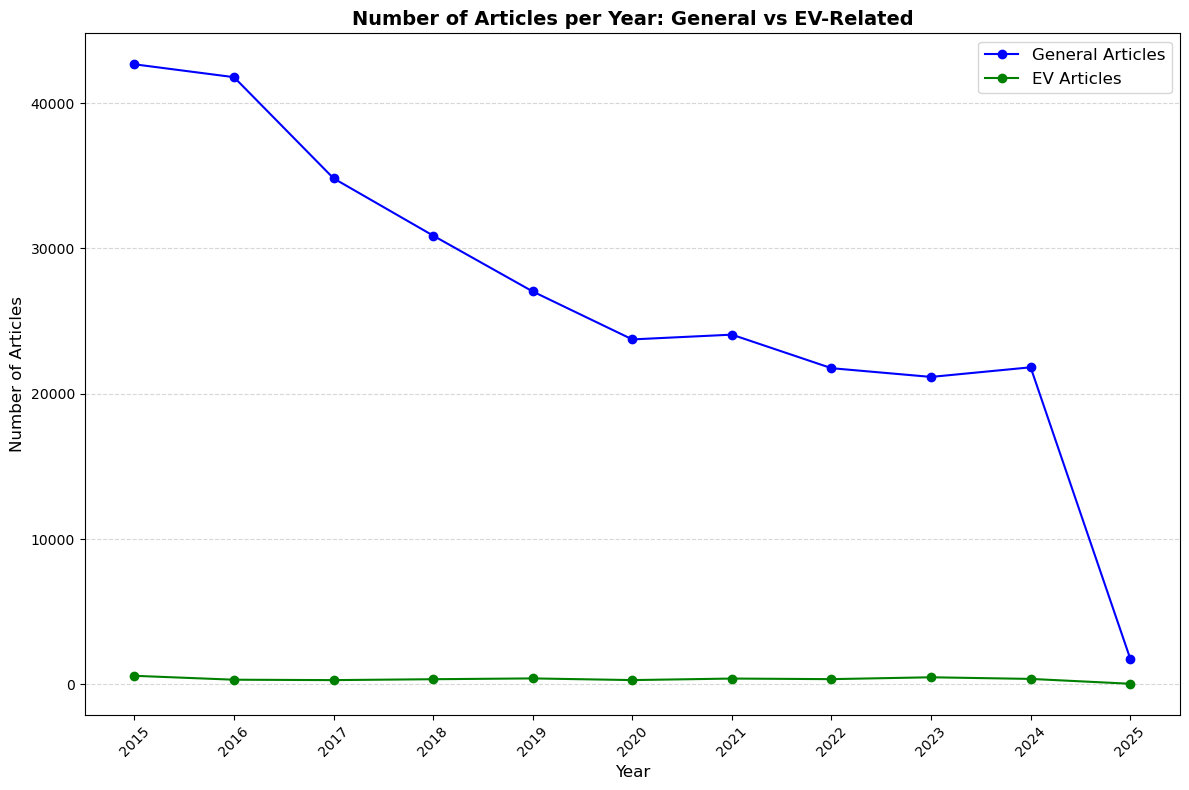

EV-related articles exported to: E:\Nieuw dataset\EV_related_articles.csv
Gemiddeld aantal EV-gerelateerde artikelen per maand: 29.61


In [21]:
# Filter rows containing any of the EV-related keywords in the 'combined_text' column
# Define a list of EV-related keywords
ev_keywords = tuple(f" {keyword} " for keyword in (
    "elektrische auto", "elektrische voertuigen", "elektrisch rijden", "stekkerauto", "emissievrij", 
    "zero emission", "elektrisch vervoer", "battery electric vehicle", "BEV", "EV", "EV-markt",
    "laadpaal", "laadinfrastructuur", "laadstation", "snelladen", "laadtijd", 
    "laadnetwerk", "opladen", "elektriciteitsnet", "netcongestie",
    "batterij", "accu", "actieradius", "solid state batterij", "energieopslag", "accutechnologie",
    "Tesla", "BYD", "Volkswagen ID", "Renault Zoe", "Hyundai Ioniq", "Kia EV", 
    "Nissan Leaf", "Polestar", "BMW i", "Ford Mustang Mach-E", "Audi e-tron",
    "subsidie elektrische auto", "aanschafsubsidie", "SEPP", "bijtelling", 
    "fiscale stimulering", "milieu-investeringsaftrek", "overheidsbeleid", "klimaatmaatregelen",
    "duurzame mobiliteit", "klimaatbeleid", "CO2-uitstoot", "groene transitie", 
    "verduurzaming vervoer", "energietransitie", "schoner verkeer",
    "tweedehands elektrische auto", "EV import", "EV export", "restwaarde EV", 
    "autoverkoop EV", "EV occasion", "elektrisch leasen"
))

# Create a mask for rows containing any of the keywords
ev_mask = df_csv['combined_text'].str.contains('|'.join(ev_keywords), case=False, na=False)

# Filter the DataFrame
df_ev = df_csv[ev_mask].copy()

# Recalculate total characters and CSV size for the filtered DataFrame
total_characters_ev = df_ev['combined_text'].str.len().sum()
csv_size_mb_ev = df_ev.memory_usage(deep=True).sum() / (1024 * 1024)

# Print the results
print(f"Totaal aantal karakters in EV-gerelateerde artikelen: {total_characters_ev}")
print(f"Grootte van de CSV met EV-gerelateerde artikelen: {csv_size_mb_ev:.2f} MB")

# Count the number of articles per channel in the filtered DataFrame
channel_counts_ev = df_ev['channel'].value_counts()

# Print the counts
print("\nAantal artikelen per kanaal (EV-gerelateerd):")
print(channel_counts_ev)
# Extract year from 'published_time' for both DataFrames
df_csv['year'] = pd.to_datetime(df_csv['published_time'], errors='coerce').dt.year
df_ev['year'] = pd.to_datetime(df_ev['published_time'], errors='coerce').dt.year

# Count the number of articles per year for both general and EV-related articles
articles_per_year = df_csv['year'].value_counts().sort_index()
ev_articles_per_year = df_ev['year'].value_counts().sort_index()

# Align the indices to ensure consistency
all_years = sorted(set(articles_per_year.index).union(ev_articles_per_year.index))
articles_per_year = articles_per_year.reindex(all_years, fill_value=0)
ev_articles_per_year = ev_articles_per_year.reindex(all_years, fill_value=0)

# Plot the data
plt.figure(figsize=(12, 8))
plt.plot(all_years, articles_per_year, label="General Articles", marker='o', color='blue')
plt.plot(all_years, ev_articles_per_year, label="EV Articles", marker='o', color='green')

# Add labels, title, and legend
plt.title("Number of Articles per Year: General vs EV-Related", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(all_years, rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

# Export the filtered DataFrame with EV-related articles to a CSV file
output_path = r"E:\Nieuw dataset\EV_related_articles.csv"
df_ev.to_csv(output_path, index=False, encoding='utf-8')

print(f"EV-related articles exported to: {output_path}")

# Calculate the average number of EV-related articles per month
average_ev_articles_per_month = ev_articles_per_year.sum() / (len(ev_articles_per_year) * 12)

# Print the result
print(f"Gemiddeld aantal EV-gerelateerde artikelen per maand: {average_ev_articles_per_month:.2f}")

In [13]:

# Export the filtered DataFrame with EV-related articles to a CSV file
output_path = r"E:\Nieuw dataset\EV_related_articles.csv"
df_ev.to_csv(output_path, index=False, encoding='utf-8')

print(f"EV-related articles exported to: {output_path}")

EV-related articles exported to: E:\Nieuw dataset\EV_related_articles.csv


 ## Jina Embeddings V3

#### Superkleine batch draaien

In [15]:
# Load the filtered EV-related articles CSV into a new DataFrame
df_ev = pd.read_csv(r"E:\Nieuw dataset\EV_related_articles.csv")


In [18]:
from sentence_transformers import SentenceTransformer

# Load the model
model = SentenceTransformer("jinaai/jina-embeddings-v3", trust_remote_code=True)

# Combine 'title', 'description', and 'content'
df_ev['combined_text'] = df_ev['title'].fillna('') + ". " + df_ev['description'].fillna('') + ". " + df_ev['content'].fillna('')

# Select a random batch (max what my computer could handle was  75)
texts = df_csv['combined_text'].sample(75, random_state=42).tolist()

# Generate embeddings as before
embeddings = model.encode(texts, task='retrieval.passage', batch_size=2, show_progress_bar=True)

print(embeddings.shape)

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

(75, 1024)


In [28]:
# Save the SentenceTransformer model to a specified directory
model_save_path = r"E:\Nieuw dataset\jina_embeddings_v3_model"
model.save(model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: E:\Nieuw dataset\jina_embeddings_v3_model


####  query toepassen (semantische search)

In [ ]:
Ja, de code in the cells above (e.g., UMAP dimensionality reduction, cosine similarity, and semantic search) is applied to the `embeddings` variable. These embeddings are generated using the `SentenceTransformer` model and represent the vectorized form of the text data (`combined_text`) for further analysis, such as clustering, visualization, or similarity calculations.

In [ ]:

# EV-related query
query = (
    "Nieuws over elektrische auto's, laadpalen, en accutechnologie.",
    "Artikelen over elektrisch rijden, EV-beleid, subsidies, en infrastructuur.",
    "Informatie over batterijtechnologie, emissievrij vervoer, en duurzame mobiliteit.",
    "Zoek naar nieuws over elektrische voertuigen, laadstations, en klimaatmaatregelen.",
    "Tesla, laadpaal, actieradius, en energietransitie in het nieuws."
)

# Average the embeddings for the queries to create a single query embedding
query_embedding = model.encode(query, task='retrieval.query').mean(axis=0)

# Calculate similarity with your small batch
similarities = cosine_similarity([query_embedding], embeddings)[0]

# Print similarity scores
for idx, score in enumerate(similarities):
    print(f"Article {idx} similarity: {score:.4f}")
    # The low similarity scores are likely due to the following reasons:
    # 1. **Keyword Filtering vs. Semantic Embedding**: The keyword filtering in cell 21 selects articles based on the presence of specific EV-related keywords. However, the embeddings generated by the SentenceTransformer model capture semantic meaning rather than exact keyword matches. This mismatch can lead to lower similarity scores if the articles contain the keywords but lack strong semantic alignment with the query.
    # 2. **Query Embedding Averaging**: In cell 23, the query embedding is created by averaging the embeddings of multiple query sentences. This averaging may dilute the specificity of the query, resulting in embeddings that are less focused and less similar to the article embeddings.
    # 3. **Batch Size and Random Sampling**: The embeddings in cell 19 are generated from a random sample of 75 articles. If the sampled articles are not strongly related to EV topics, the similarity scores will naturally be lower.
    # 4. **Cosine Similarity Range**: Cosine similarity values typically range between -1 and 1, but for high-dimensional embeddings, values close to 0 are common unless the vectors are highly aligned. This is especially true for embeddings that are not explicitly fine-tuned for the specific task or domain.

    # To improve similarity scores:
    # - Use a more focused query or fine-tune the model on EV-related data.
    # - Ensure the sampled articles are representative of the EV domain.
    # - Consider using a weighted average for query embeddings to emphasize more relevant sentences.

Article 0 similarity: 0.0416
Article 1 similarity: -0.0032
Article 2 similarity: 0.0020
Article 3 similarity: 0.1035
Article 4 similarity: -0.0202
Article 5 similarity: 0.0188
Article 6 similarity: 0.0837
Article 7 similarity: 0.0339
Article 8 similarity: -0.0207
Article 9 similarity: 0.0708
Article 10 similarity: -0.0206
Article 11 similarity: 0.1305
Article 12 similarity: 0.0169
Article 13 similarity: 0.0228
Article 14 similarity: -0.0360
Article 15 similarity: 0.1057
Article 16 similarity: 0.1596
Article 17 similarity: -0.0263
Article 18 similarity: 0.1176
Article 19 similarity: 0.0184
Article 20 similarity: 0.0435
Article 21 similarity: 0.0982
Article 22 similarity: 0.1554
Article 23 similarity: -0.0586
Article 24 similarity: -0.0166
Article 25 similarity: 0.0659
Article 26 similarity: -0.0161
Article 27 similarity: 0.1700
Article 28 similarity: 0.0835
Article 29 similarity: 0.1302
Article 30 similarity: 0.0114
Article 31 similarity: -0.0094
Article 32 similarity: 0.0632
Article 33

In [31]:
# Combine indices and scores
results = list(enumerate(similarities))
# Sort by score, highest first
results = sorted(results, key=lambda x: x[1], reverse=True)

# Print the sorted results
for idx, score in results:
    print(f"\nArticle {idx} similarity: {score:.4f}")
    print(f"Title: {df_csv.iloc[idx]['title']}")
    print(f"Description: {df_csv.iloc[idx]['description']}")
    print(f"Content (snippet): {df_csv.iloc[idx]['content'][:200]}...")
    print(f"url: {df_csv.iloc[idx]['url']}")



Article 55 similarity: 0.2399
Title: Chelsea onderuit in spektakelstuk
Description: De formatie van José Mourinho werd in een doelpuntrijk duel met 5-3 verslagen door Tottenham Hotspur. Manchester City staat nu op gelijke hoogte.
Content (snippet): Chelsea onderuit in spektakelstuk Tottenham Hotspur heeft Chelsea getrakteerd op een even ruime als kostbare nederlaag. Op het eigen White Hart Lane waren de Spurs met 5-3 te sterk voor de titelkandid...
url: https://nos.nl/artikel/2011427-chelsea-onderuit-in-spektakelstuk

Article 33 similarity: 0.2028
Title: Assad bezoekt Syrische frontlinie
Description: Op de staatstelevisie was te zien hoe president Assad een deel van Oudjaarsavond doorbracht met militairen. 
Content (snippet): Assad bezoekt Syrische frontlinie De Syrische leider Assad heeft een deel van Oudjaarsavond doorgebracht bij de frontlinie. Hij dineerde met militairen in de wijk Jobar in de hoofdstad Damascus. Op de...
url: https://nos.nl/artikel/2011394-assad-bezoekt-syrische-

c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


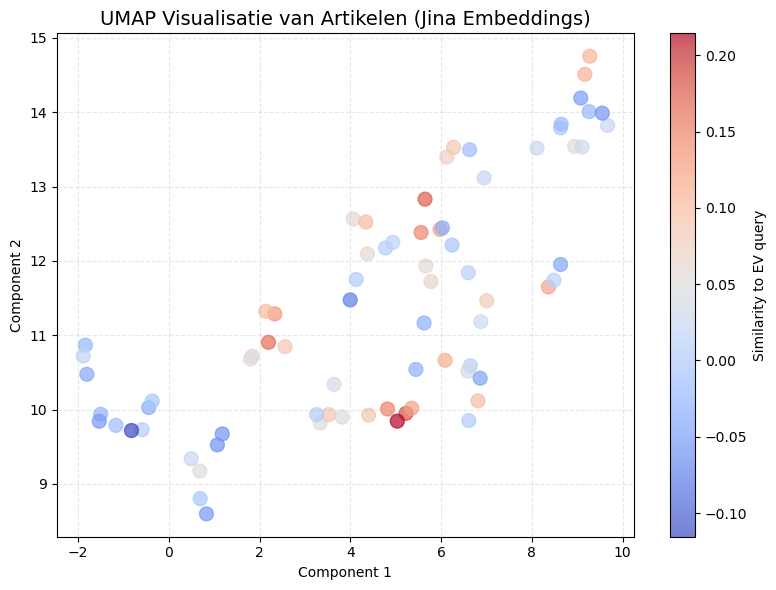

In [31]:

# Stap 1: Reduceer je embeddings naar 2D
reducer = umap.UMAP(n_neighbors=3, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)  # gebruik jouw embeddings hier

# Stap 2: Voeg coördinaten toe aan je DataFrame (bijv. df_csv.head(5))
df_sample = df_csv.head(75).copy()
df_sample["x"] = embedding_2d[:, 0]
df_sample["y"] = embedding_2d[:, 1]

# Stap 3: Voeg similarity als kleur toe (bijv. hoe dicht bij EV)
df_sample["similarity"] = similarities  # jouw similarity scores

# Stap 4: Plot de scatterplot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_sample["x"],
    df_sample["y"],
    c=df_sample["similarity"],
    cmap="coolwarm",
    s=100,  # grootte van de punten
    alpha=0.7
)
plt.colorbar(scatter, label="Similarity to EV query")
plt.title("UMAP Visualisatie van Artikelen (Jina Embeddings)", fontsize=14)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()
